In [1]:
import sys
from pathlib import Path

import numpy as np
from astropy import table
import random
from scipy import interpolate, optimize, signal
import betterplotlib as bpl

bpl.set_style()

# Get all the final postprocessed output catalogs

In [2]:
data_dir = Path("../data/").resolve()

In [3]:
catalogs = []
for galaxy in data_dir.iterdir():
    for item in (data_dir / galaxy / "size").iterdir():
        if item.name.startswith("final_catalog_final_30") and "ryonlike" not in item.name:
            this_cat = table.Table.read(item, format="ascii.ecsv")
            this_cat["galaxy"] = galaxy.name
            if "not_failure" in this_cat.colnames:
                catalogs.append(this_cat)
            else:
                print(galaxy.name, item.name)

In [4]:
big_catalog = table.vstack(catalogs, join_type="inner")

In [5]:
mask = big_catalog["not_failure"]

In [6]:
print(len(big_catalog), "total clusters")
print(np.sum(mask), "clusters with good fits")
fail_fraction = (len(big_catalog) - np.sum(mask)) / len(big_catalog)
print(f"{100*fail_fraction:.3f}% of clusters failed")

7609 total clusters
7096 clusters with good fits
6.742% of clusters failed


# Then make cumulative histograms of some of the fit quality metrics

In [7]:
def make_cumulative_histogram(values):
    """
    Create the line to be plotted for a cumulative histogram
    
    Throws out nans

    :param values: data
    :return: List of xs and ys to be plotted for the cumulative histogram
    """
    sorted_values = np.sort(values)
    # throw out nans
    sorted_values = sorted_values[~np.isnan(sorted_values)]
    ys = np.arange(1, 1 + len(sorted_values), 1)
    assert len(ys) == len(sorted_values)
    return sorted_values, ys / max(ys)

In [8]:
quality_colnames = ["profile_diff_reff"]  # can add more quantities here

In [9]:
boundaries = dict()
for col in quality_colnames:
    if "rms" in col:
        continue
    xs, ys = make_cumulative_histogram(big_catalog[col][mask])
    # find the first x at which y goes above 0.9
    idx = np.argmin(np.abs(ys - 0.9))
    boundaries[col] = xs[idx]

In [10]:
# boundaries["fractional_err_max"] = 0.3

In [11]:
# fig, axs = bpl.subplots(ncols=len(quality_colnames), figsize=[6*len(quality_colnames), 6])
# axs = axs.flatten()

# for ax, col in zip(axs, quality_colnames):
#     ax.plot(*make_cumulative_histogram(big_catalog[col][mask]))
#     ax.add_labels(col, "Fraction of Clusters")
#     ax.set_limits(0, y_min=0, y_max=1)
#     ax.axhline(0.9, ls="--")
#     ax.axvline(boundaries[col], ls="--")
# fig.savefig("quality_cuts.png")

In [12]:
names = {
    "profile_diff_mad": "Median Profile Deviation",
    "profile_diff_last": "Profile Deviation at 3 $R_{eff}$",
    "profile_diff_max": "Maximum Profile Deviation",
    "profile_diff_reff": "Profile Deviation at Estimated $R_{eff}$",
    "fractional_err_max": "Relative Error on $R_{eff}$"
}

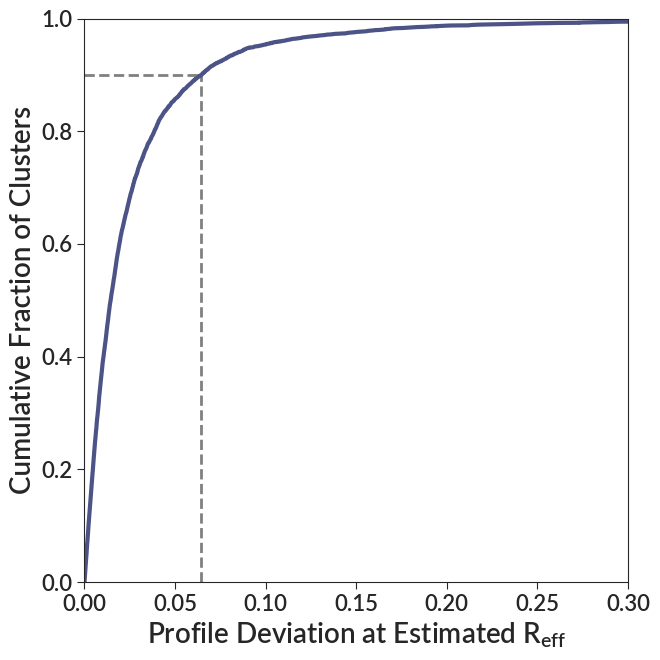

In [13]:
fig, ax = bpl.subplots(figsize=[7, 7])

ax.plot(*make_cumulative_histogram(big_catalog["profile_diff_reff"][mask]), 
            label=names["profile_diff_reff"], c=bpl.color_cycle[0], lw=3)

x_max = 0.3
ax.axvline(boundaries["profile_diff_reff"], ls="--", c="0.5", lw=2, ymax=0.9, zorder=0)
ax.axhline(0.9, ls="--", c="0.5", zorder=0, lw=2, xmax=boundaries["profile_diff_reff"]/x_max)

ax.add_labels("Profile Deviation at Estimated $R_{eff}$", "Cumulative Fraction of Clusters")
ax.set_limits(0, x_max, 0, 1)
# ax.legend(fontsize=13, loc=5)
fig.savefig("quality_cuts_paper.pdf")

For a final version, using the second derivative would probably be a more quantitiative version of doing this, but for now we'll just throw out the last 10%.

In [14]:
boundaries

{'profile_diff_reff': 0.06452328484307997}

In [15]:
# good_colnames = []
# for col in boundaries:
#     big_catalog[col + "_good"] = big_catalog[col] < boundaries[col]
    
#     good_colnames.append(col + "_good")

Then print out how many met each criteria, and how those intersected.

In [16]:
# big_catalog["num_failed"] = -99
# for row in big_catalog:
#     row["num_failed"] = 2 - np.sum([row[col] for col in good_colnames])

In [17]:
# def print_row(row):
#     output = "\t\t"
#     output += f"{row['galaxy']:9} {row['ID']:5}, "
#     output += f"R_eff {row['r_eff_pixels_rmax_15pix_best']:5.2f} pix, "
#     output += f"max {row['profile_diff_max']:4.2f}, "
#     output += f"reff {row['profile_diff_reff']:4.2f}, "
# #     output += f"last {row['profile_diff_last']:4.2f}, "
# #     output += f"RMS {row['fit_rms']:6.2f}, "
#     print(output)

# n_total = len(big_catalog)
# print(n_total, "total clusters")


# for n_fail in range(3):
#     mask = big_catalog["num_failed"] == n_fail
#     subset = big_catalog[mask]
    
#     print(f"\n\n{100 * len(subset) / len(big_catalog):.2f}% of clusters failed {n_fail} criteria")
    
#     if n_fail == 0:
#         for i in np.random.randint(low=0, high=len(subset), size=30):
#             print_row(subset[i])
    
#     if n_fail == 1:
#         for col in good_colnames:
#             failure_mask = subset[col] == False
#             n_failure = np.sum(failure_mask)
#             print(f"\t{100*n_failure/n_total:.2f}% of these solely failed {col}")
#             for i in np.random.randint(low=0, high=n_failure, size=10):
#                 print_row(subset[failure_mask][i])
            
# #     if n_fail == 2:
# #         for col in good_colnames:
# #             success_mask = subset[col] == True
# #             n_success = np.sum(success_mask)
# #             print(f"\t{100*n_success/n_total:.2f}% of these solely passed {col}")
# #             for row in subset[success_mask][:10]:
# #                 print_row(row)
#     if n_fail == 2:
#         for i in np.random.randint(low=0, high=len(subset), size=30):
#             print_row(subset[i])